In [1]:
#!pip install beautifulsoup4

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import time
import copy
from sklearn.datasets import make_classification
from alipy import ToolBox
from bs4 import BeautifulSoup
import re

In [3]:
# Check Gpu
tf.test.gpu_device_name()

2022-03-09 09:05:04.203003: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


'/device:GPU:0'

2022-03-09 09:05:05.249327: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 47221 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:3b:00.0, compute capability: 7.5
2022-03-09 09:05:05.249991: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:1 with 47221 MB memory:  -> device: 1, name: Quadro RTX 8000, pci bus id: 0000:d8:00.0, compute capability: 7.5


In [4]:
# Import the Dataset
#df = pd.read_csv('data/train.csv', nrows=10000)

df = pd.read_csv('data/train.csv', nrows=7000)
df

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."
...,...,...,...
6995,3,Oil raises economists #39; concerns,WASHINGTON - Crude oil prices soaring to nearl...
6996,4,Advanced Model of World #39;s Smallest Flying ...,Epson has long been engaged in the research an...
6997,4,Which Candidates Do Tech Companies Support?,In a down year for tech industry contributions...
6998,2,Moore battles back to top List at US amateur c...,Ryan Moore staged a remarkable comeback to ove...


In [5]:
print(df.shape)

(7000, 3)


In [6]:
# Limit dataframe to work faster
#df = df[:500]
df['Class Index'].value_counts()

1    1861
4    1820
2    1683
3    1636
Name: Class Index, dtype: int64

In [7]:
df.dropna()

# Combine title and description (better accuracy than using them as separate features)
df['Content'] = df['Title'] + " " + df['Description']

# Drop both of the columns because meaningfull data is in Content columns
df = df.drop(['Title', 'Description'], axis=1)

# Class labels need to begin from 0 
df ['Class Index'] = df['Class Index'].apply(lambda x: x-1).values 

df

,Class Index,Content
0,2,Wall St. Bears Claw Back Into the Black (Reute...
1,2,Carlyle Looks Toward Commercial Aerospace (Reu...
2,2,Oil and Economy Cloud Stocks' Outlook (Reuters...
3,2,Iraq Halts Oil Exports from Main Southern Pipe...
4,2,"Oil prices soar to all-time record, posing new..."
...,...,...
6995,2,Oil raises economists #39; concerns WASHINGTON...
6996,3,Advanced Model of World #39;s Smallest Flying ...
6997,3,Which Candidates Do Tech Companies Support? In...
6998,1,Moore battles back to top List at US amateur c...


In [8]:
#df['sentiment'] = df.astype(int)
df['Class Index'].value_counts()

0    1861
3    1820
1    1683
2    1636
Name: Class Index, dtype: int64

In [9]:
df['Content']

0       Wall St. Bears Claw Back Into the Black (Reute...
1       Carlyle Looks Toward Commercial Aerospace (Reu...
2       Oil and Economy Cloud Stocks' Outlook (Reuters...
3       Iraq Halts Oil Exports from Main Southern Pipe...
4       Oil prices soar to all-time record, posing new...
                              ...                        
6995    Oil raises economists #39; concerns WASHINGTON...
6996    Advanced Model of World #39;s Smallest Flying ...
6997    Which Candidates Do Tech Companies Support? In...
6998    Moore battles back to top List at US amateur c...
6999    CMS Energy to Offer \$200 Million Notes CMS En...
Name: Content, Length: 7000, dtype: object

In [10]:
# Our first step is to tokenize the sentences -- break them up into word and subwords in the format BERT is comfortable with.

# Create Bert tokenizer class
tokenizer_class = ppb.BertTokenizer

# Save the weights for uncased Bert 
pretrained_weights = 'bert-base-cased'

# Create a tokenizer from tokenizer class
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)

# Tokenize all of the sentences 
tokenized = df['Content'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512, truncation=True)))

In [11]:
len(tokenized[0])

45

In [12]:
tokenized.shape

(7000,)

In [13]:
# Add padding to all of the sentences so that they have the same size
# So the input can be represented as a 2d array
# Important for performance

max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

padded

array([[  101,  6250,  1457, ...,     0,     0,     0],
       [  101, 19879,  1513, ...,     0,     0,     0],
       [  101,  9105,  1105, ...,     0,     0,     0],
       ...,
       [  101,  5979,  2825, ...,     0,     0,     0],
       [  101,  4673,  7619, ...,     0,     0,     0],
       [  101,   140,  7182, ...,     0,     0,     0]])

In [14]:
np.array(padded).shape

(7000, 384)

In [15]:
# Attention mask is created to mask the padded values
attention_mask = np.where(padded != 0, 1, 0)
attention_mask

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [16]:
attention_mask.shape

(7000, 384)

In [17]:
# For DistilBERT:

# Create config just in case 
config = ppb.BertConfig(output_hidden_states=True)
model_class = ppb.BertModel(config=config)

# Load pretrained model/tokenizer
model = model_class.from_pretrained(pretrained_weights)


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [18]:
# Check model config 
model.config

BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.16.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

In [19]:
# Transform padded to a tensor 
input_ids = torch.tensor(padded)  

# Transfer mask to a tensor 
attention_mask = torch.tensor(attention_mask)

# Run the sentences through BERT save the states of each layer to hidden_states
with torch.no_grad():    
    outputs = model(input_ids, attention_mask=attention_mask, output_hidden_states=True)

In [20]:
len(outputs)

3

In [21]:
#outputs[2] gets all of the 12 layers

hidden_states = outputs[2]

In [22]:
len(hidden_states)

13

In [23]:
embedding_output = hidden_states[0]

layer_1 = hidden_states[1]
layer_2 = hidden_states[2]
layer_3 = hidden_states[3]
layer_4 = hidden_states[4]
layer_5 = hidden_states[5]
layer_6 = hidden_states[6]
layer_7 = hidden_states[7]
layer_8 = hidden_states[8]
layer_9 = hidden_states[9]
layer_10 = hidden_states[10]
layer_11 = hidden_states[11]
layer_12 = hidden_states[12]

In [24]:
layer_12.shape

torch.Size([7000, 384, 768])

In [25]:
# Let's slice only the part of the output that we need. That is the output corresponding the first token of each sentence. 
# The way BERT does sentence classification, is that it adds a token called [CLS] (for classification) at the beginning of every sentence. 
# The output corresponding to that token can be thought of as an embedding for the entire sentence.
# We'll save those in the features variable, as they'll serve as the features to our random forest classifier.

features_1 = layer_1[:,0,:].numpy()
features_2 = layer_2[:,0,:].numpy()
features_3 = layer_3[:,0,:].numpy()
features_4 = layer_4[:,0,:].numpy()
features_5 = layer_5[:,0,:].numpy()
features_6 = layer_6[:,0,:].numpy()
features_7 = layer_7[:,0,:].numpy()
features_8 = layer_8[:,0,:].numpy()
features_9 = layer_9[:,0,:].numpy()
features_10 = layer_10[:,0,:].numpy()
features_11 = layer_11[:,0,:].numpy()
features_12 = layer_12[:,0,:].numpy()

labels = df['Class Index']
labels_np = labels.to_numpy()

labels_np.shape

(7000,)

In [26]:
#Do active learning with y_confidence values but how?

#!pip install alipy

total_time = []

In [27]:
# Define active learning loop using ALiPy
# Check http://parnec.nuaa.edu.cn/_upload/tpl/02/db/731/template731/pages/huangsj/alipy/example.html#collapseOne

def main_loop(alibox, strategy, round):
        # Get the data split of one fold experiment
        train_idx, test_idx, label_ind, unlab_ind = alibox.get_split(round)
        # Get intermediate results saver for one fold experiment
        saver = alibox.get_stateio(round, saving_path=f"./{strategy.__class__.__name__}_{round}.pkl")

        # Set initial performance point
        model.fit(X=X[label_ind.index, :], y=y[label_ind.index])
        pred = model.predict(X[test_idx, :])
        accuracy = alibox.calc_performance_metric(y_true=y[test_idx],
                                                  y_pred=pred,
                                                  performance_metric='accuracy_score')
        saver.set_initial_point(accuracy)

        # If the stopping criterion is simple, such as query 50 times. Use `for i in range(50):` is ok.
        while not stopping_criterion.is_stop():
            # Select a subset of Uind according to the query strategy
            # Passing model=None to use the default model for evaluating the committees' disagreement
            # Set batch size 2
            select_ind = strategy.select(label_index=label_ind, unlabel_index=unlab_ind, batch_size=32, model=model)
            label_ind.update(select_ind)
            unlab_ind.difference_update(select_ind)
            
            
            start = time.time()
            # Update model and calc performance according to the model you are using
            model.fit(X=X[label_ind.index, :], y=y[label_ind.index])
            end = time.time()
            
            iteration_time = end-start
            total_time.append(iteration_time)
            
            pred = model.predict(X[test_idx, :])
            accuracy = alibox.calc_performance_metric(y_true=y[test_idx],
                                                      y_pred=pred,
                                                      performance_metric='accuracy_score')

            # Save intermediate results to file
            st = alibox.State(select_index=select_ind, performance=accuracy)
            saver.add_state(st)
            saver.save()

            # Passing the current progress to stopping criterion object
            stopping_criterion.update_information(saver)
        # Reset the progress in stopping criterion object
        stopping_criterion.reset()
        return saver

In [28]:
# Define some stuff for AL loop

n_iteration = 1200 


In [29]:
# Create holders for uncertantiy sampling results for each different layer

unc_result_1 = []
unc_result_2 = []
unc_result_3 = []
unc_result_4 = []
unc_result_5 = []
unc_result_6 = []
unc_result_7 = []
unc_result_8 = []
unc_result_9 = []
unc_result_10 = []
unc_result_11 = []
unc_result_12 = []

unc_result_add_last_4 = []
unc_result_cct_last_4 = []


unc_results = (unc_result_1, unc_result_2, unc_result_3, unc_result_4, unc_result_5, unc_result_6,
                unc_result_7, unc_result_8, unc_result_9, unc_result_10, unc_result_11, unc_result_12,
                unc_result_add_last_4, unc_result_cct_last_4)

In [30]:
# Save the CLS values in a list to iterate them on the model
CLS_layers = ()

In [31]:
# get layer combinations for addition

add_5_6 = np.add(features_5, features_6)
add_7_8 = np.add(features_7, features_8)
add_9_10 = np.add(features_9, features_10)
add_11_12 = np.add(features_11, features_12)


add_9_12 = np.add(add_9_10, add_11_12)

add_7_10 = np.add(add_7_8, add_9_10)

add_5_8 = np.add(add_5_6, add_7_8)



In [32]:
CLS_layers = (features_1, features_2, features_3, features_4, features_5, features_6, features_7,
                features_8, features_9, features_10, features_11, features_12, add_7_10, add_9_12)

In [33]:
for i in range(len(CLS_layers)):

    X=CLS_layers[i]
    y=labels_np

    alibox = ToolBox(X=X, y=y, query_type='AllLabels', saving_path='.')

    # Split data
    alibox.split_AL(test_ratio=0.3, initial_label_rate=0.1, split_count=10)

    # Use the default Logistic Regression classifier
    model = alibox.get_default_model()

    # The cost budget is 50 times querying
    stopping_criterion = alibox.get_stopping_criterion('num_of_queries', n_iteration)
    

    for round in range(5):
        train_idx, test_idx, label_ind, unlab_ind = alibox.get_split(round)

        # Use pre-defined strategy
        unc = alibox.get_query_strategy(strategy_name="QueryInstanceUncertainty")

        unc_results[i].append(copy.deepcopy(main_loop(alibox, unc, round)))
        


| round | initially labeled data | number of queries | cost | Performance: |
|   0   |   490 (10.00% of all)  |        138        |  0   | 0.810 ± 0.01 |
| round | initially labeled data | number of queries | cost | Performance: |
|   1   |   490 (10.00% of all)  |        138        |  0   | 0.816 ± 0.01 |
| round | initially labeled data | number of queries | cost | Performance: |
|   2   |   490 (10.00% of all)  |        138        |  0   | 0.806 ± 0.02 |
| round | initially labeled data | number of queries | cost | Performance: |
|   3   |   490 (10.00% of all)  |        138        |  0   | 0.819 ± 0.01 |
| round | initially labeled data | number of queries | cost | Performance: |
|   4   |   490 (10.00% of all)  |        138        |  0   | 0.814 ± 0.01 |
| round | initially labeled data | number of queries | cost | Performance: |
|   0   |   490 (10.00% of all)  |        138        |  0   | 0.829 ± 0.01 |
| round | initially labeled data | number of queries | cost | Performance: 


+----------------+-------------------+---------------------------+--------------+------------+
|    Methods     | number_of_queries | number_of_different_split | performance  | batch_size |
+----------------+-------------------+---------------------------+--------------+------------+
|  Unc_Layer_12  |        138        |             5             | 0.854 ± 0.01 |     32     |
|  Unc_Layer_11  |        138        |             5             | 0.843 ± 0.00 |     32     |
|  Unc_Layer_10  |        138        |             5             | 0.845 ± 0.01 |     32     |
|  Unc_Layer_9   |        138        |             5             | 0.852 ± 0.00 |     32     |
|  Unc_Layer_8   |        138        |             5             | 0.849 ± 0.01 |     32     |
|  Unc_Layer_7   |        138        |             5             | 0.853 ± 0.01 |     32     |
|  Unc_Layer_6   |        138        |             5             | 0.854 ± 0.01 |     32     |
|  Unc_Layer_5   |        138        |           

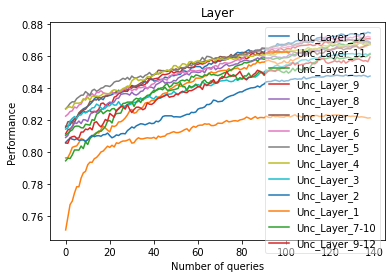

In [38]:
analyser = alibox.get_experiment_analyser(x_axis='num_of_queries')


for i in range(len(unc_results)-2):
    
    # Iterationg results in reverse beacues 12th layer has the best performance and will stay at top
    # On the plot we want to somehow corralete the layer and the plot
    analyser.add_method(method_name='Unc_Layer_' + str(len(CLS_layers)-i-2), method_results=unc_results[len(CLS_layers)-i-3])        
    
analyser.add_method(method_name='Unc_Layer_7-10' , method_results=unc_results[12])
analyser.add_method(method_name='Unc_Layer_9-12' , method_results=unc_results[13])
    
print(analyser)
analyser.plot_learning_curves(title='Layer', std_area=False)

In [35]:
avg_time = sum(total_time) / len(total_time)
    
print('FOR 14 TRANSFORMER BLOCKS' )
print('1200 Queries')
print('5 different train/test splits')
print("-----------------------------------------")
print("Average Runtime For one Transformer Block")
print(avg_time)
               
print("Maximum Runtime For one Query")
print(max(total_time))
               
print("Minimum Runtime For one Query")
print(min(total_time))

print("Total Time")
print(sum(total_time))

FOR 14 TRANSFORMER BLOCKS
1200 Queries
5 different train/test splits
-----------------------------------------
Average Runtime For one Transformer Block
2.617471608143169
Maximum Runtime For one Query
15.824809551239014
Minimum Runtime For one Query
0.12636327743530273
Total Time
25284.77573466301


In [39]:
unc_results[1]

[| round | initially labeled data | number of queries | cost | Performance: |
 |   0   |   490 (10.00% of all)  |        138        |  0   | 0.829 ± 0.01 |,
 | round | initially labeled data | number of queries | cost | Performance: |
 |   1   |   490 (10.00% of all)  |        138        |  0   | 0.845 ± 0.02 |,
 | round | initially labeled data | number of queries | cost | Performance: |
 |   2   |   490 (10.00% of all)  |        138        |  0   | 0.811 ± 0.02 |,
 | round | initially labeled data | number of queries | cost | Performance: |
 |   3   |   490 (10.00% of all)  |        138        |  0   | 0.835 ± 0.01 |,
 | round | initially labeled data | number of queries | cost | Performance: |
 |   4   |   490 (10.00% of all)  |        138        |  0   | 0.833 ± 0.01 |]

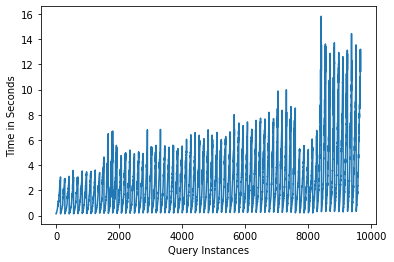

In [36]:
import matplotlib.pyplot as plt

plt.plot(total_time)
plt.ylabel('Time in Seconds')
plt.xlabel('Query Instances')
plt.show()